# CNN Vegetables Classification

### Antonio Caballero Carrasco

## Imports

In [1]:
from torchvision import models, datasets, transforms
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Carga del dataset

El dataset usado se ha obtenido de: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset. La motivación para el uso de este dataset es el número de clases diferentes, que lo hace intersante para probar el potencial de clasificación de redes CNN.

In [2]:
datasetPath = './data'

# Carga del trainset
trainsetPath = os.path.join(datasetPath, 'train')

categories = os.listdir(trainsetPath)
categories.sort()
print(categories)


['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


### Mostrar una imagen de cada categoria

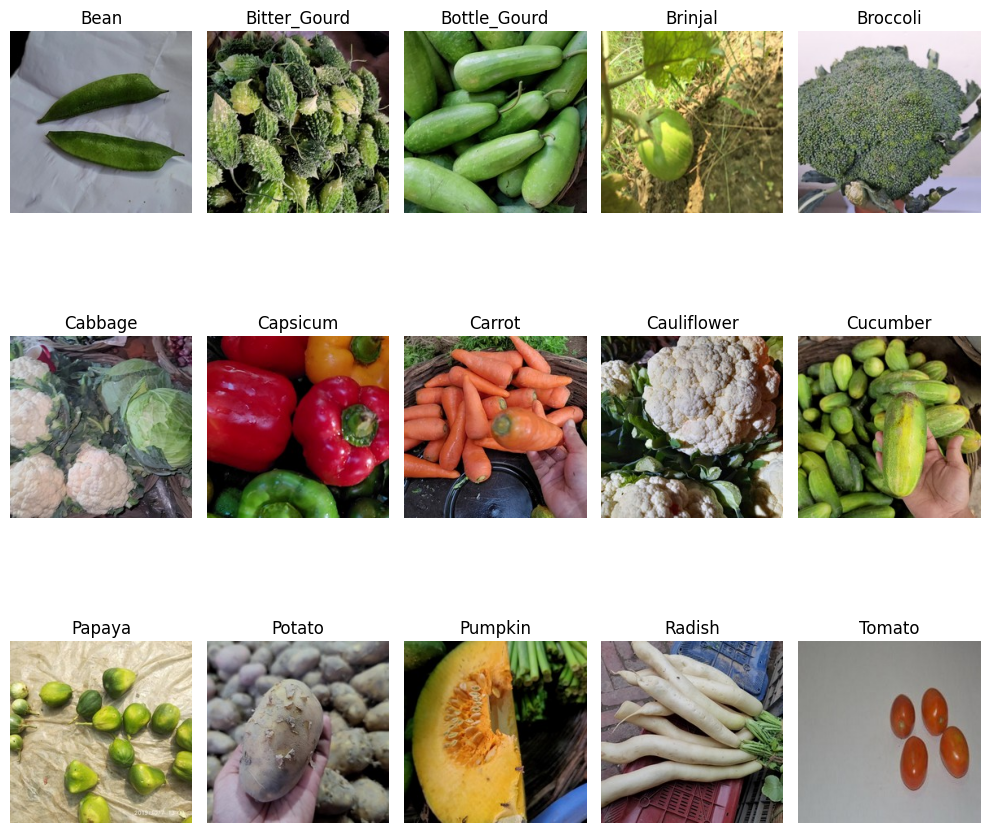

In [3]:
# Visualización de un sample de cada categoría
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()

for idx, dir in enumerate(categories):
    dirLen = len(os.listdir(os.path.join(trainsetPath, dir)))
    indiceAleatorio = np.random.randint(0, dirLen)
    img_path = os.path.join(trainsetPath, dir, os.listdir(os.path.join(trainsetPath, dir))[indiceAleatorio])
    img = plt.imread(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(dir)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## Creación del dataset de pruebas con DataAugmentation

In [4]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

data_augmentation_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    preprocess
])

print(f"Categorias: {categories}")

# Load the dataset with preprocessing
trainset = datasets.ImageFolder(trainsetPath, preprocess)


# trainset_augmented = datasets.ImageFolder(trainsetPath, data_augmentation_transformer)
# trainset = torch.utils.data.ConcatDataset([trainset, trainset_augmented])

print(f'Tamaño del set de entrenamiento: {len(trainset)}')

Categorias: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Tamaño del set de entrenamiento: 15000


Aunque se ha comentado, esa sería la manera de aumentar el tamaño del dataset para lograr un entrenamiento más preciso.

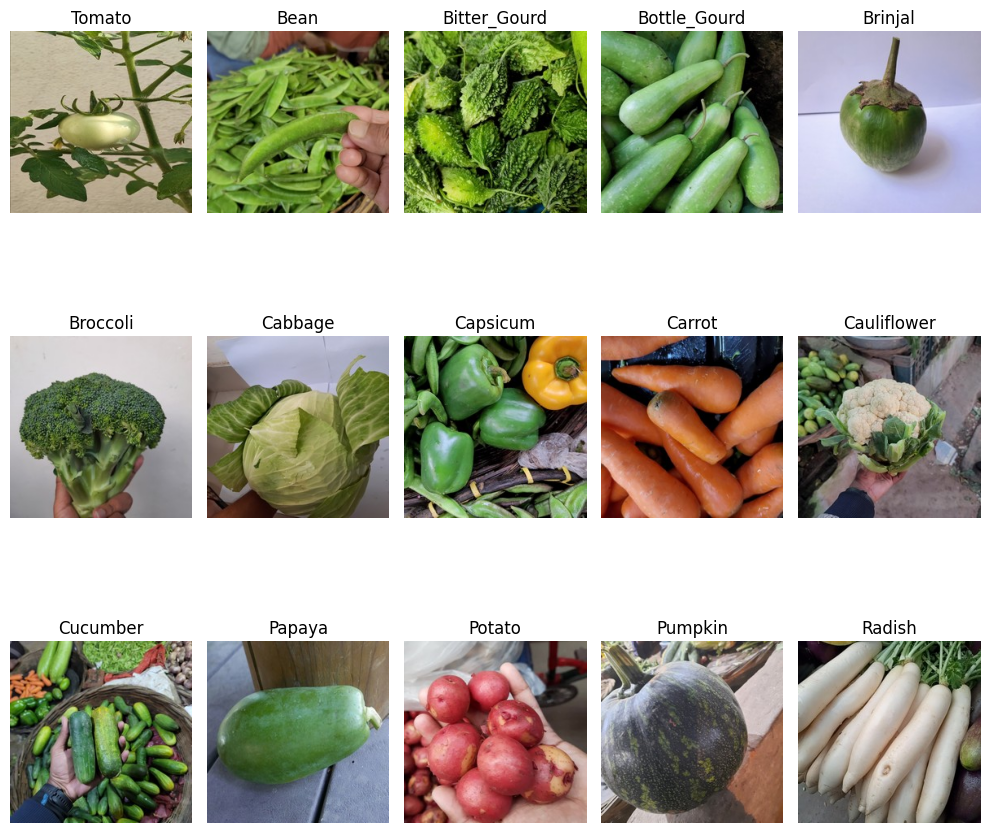

In [5]:
# Mostrar 15 samples ya preprocesadas

fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()

for i in range(15):
    img, label = trainset[i*1000 -1]
    img = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(categories[label])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Creación de los dataloaders de entrenamiento, validación y test

In [6]:
batchSize = 32

validationsetPath = os.path.join(datasetPath, 'validation')
validationset = datasets.ImageFolder(validationsetPath, preprocess)
print(f'Tamaño del set de validación: {len(validationset)}')

testsetPath = os.path.join(datasetPath, 'test')
testset = datasets.ImageFolder(testsetPath, preprocess)
print(f'Tamaño del set de test: {len(testset)}')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batchSize, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False)

Tamaño del set de validación: 3000
Tamaño del set de test: 3000


## Cargar un modelo ResNet50

Se opta por un modelo CNN con transfere learning desde el modelo ResNet50 preentrenado. Haciendo un fine tune para que sea capaz de clasificar los diferentes vegetales. Es decir, se aprovecha todo el conocimiento ya aprendido en la red ResNet50 para observer y comprender conceptos geométricos propios de la visión artificial y solo se realiza un ajuste despues de las capas convolutivas para poder clasificar imagenes de contexto más específicos.

### Hiperparámetros

In [7]:
batchSize = 64
lR = 1e-3 # Learning rate
nEpochs = 1



Basta con 1 epochs para lograr un buen accuraccy, pues la gran parte de la clasificación ya se usa entrenada en ResNet50.

### Definición del modelo

In [8]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(categories)) # Se cambia la última capa por una de salida con el número de categorías

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lR)

savePath = './best_model.pth'


# model.fc = torch.nn.Sequential(
#     torch.nn.Dropout(0.5),
#     torch.nn.Linear(num_ftrs, len(categories))
# ).to(device)


# model

/home/antonio/anaconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/antonio/anaconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Entrenamiento del modelo

In [9]:
import tqdm
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True
    
trainLosess = []
validationLosess = []
trainAccuracies = []
validationAccuracies = []

model.train()
train_loader_tqdm = tqdm.tqdm(trainloader, desc='Training', dynamic_ncols=True)

best_accuracy = 0.0

for epoch in range(nEpochs):
    for input, labels in train_loader_tqdm:
        input = input.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        trainLosess.append(loss.item())
        
        _, predicted = outputs.max(1)
        total = labels.size(0)
        correct = predicted.eq(labels).sum().item()
        accuracy = 100 * correct / total
        trainAccuracies.append(accuracy)
        
        train_loader_tqdm.set_postfix(loss=loss.item(), accuracy=accuracy)

    model.eval()
    val_loader_tqdm = tqdm.tqdm(validationloader, desc='Validation', dynamic_ncols=True)
    with torch.no_grad():
        for input, labels in val_loader_tqdm:
            input = input.to(device)
            labels = labels.to(device)
            
            outputs = model(input)
            loss = criterion(outputs, labels)
            validationLosess.append(loss.item())
            
            _, predicted = outputs.max(1)
            total = labels.size(0)
            correct = predicted.eq(labels).sum().item()
            accuracy = 100 * correct / total
            validationAccuracies.append(accuracy)
            
            val_loader_tqdm.set_postfix(loss=loss.item(), accuracy=accuracy)
    
    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), savePath)



Validation: 100%|██████████| 94/94 [00:11<00:00,  8.43it/s, accuracy=100, loss=0.0355] 


El mejor modelo queda guardado en best_model_weights.pth que luego se usara en vegetableAPP.py

### Evaluación del modelo

In [10]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
test_loader_tqdm = tqdm.tqdm(testloader, desc=f'Test', dynamic_ncols=True)
with torch.no_grad():
    for input, labels in test_loader_tqdm:
        input = input.to(device)
        labels = labels.to(device)

        outputs = model(input)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        test_loader_tqdm.set_postfix(loss=test_loss / total, accuracy=correct / total)

epoch_test_loss = test_loss / total
epoch_test_accuracy = 100 * (correct / total)
print (f'Test loss: {epoch_test_loss} - Test accuracy: {epoch_test_accuracy}')

Test: 100%|██████████| 94/94 [00:11<00:00,  8.36it/s, accuracy=0.995, loss=0.00107] 

Test loss: 0.0010674417836902042 - Test accuracy: 99.53333333333333


 Dado que el modelo es un Transfer Learning de ResNet50 con ajuste fino en la capa de clasificación, con solo una epochs podemos ver un alto nivel de accuracy. Que en este caso parece presentar overfitting. Aún así es el modelo funciona con bastante fiabilidad para su tarea de clasificar alimentos vegetales.
 

## Metricas de Evaluación

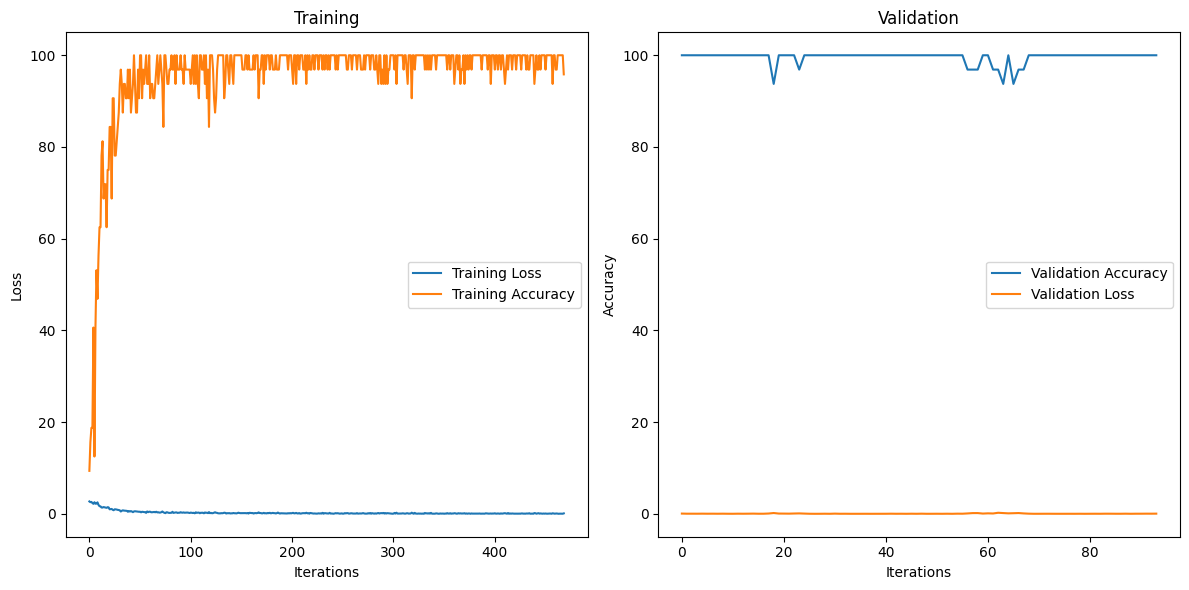

In [14]:
# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(trainLosess, label='Training Loss')
plt.plot(trainAccuracies, label='Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training')
plt.legend()

# Graficar las accuracies de entrenamiento y validación
plt.subplot(1, 2, 2)

plt.plot(validationAccuracies, label='Validation Accuracy')
plt.plot(validationLosess, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Validation')
plt.legend()

plt.tight_layout()
plt.show()

## Muestra de clasificación

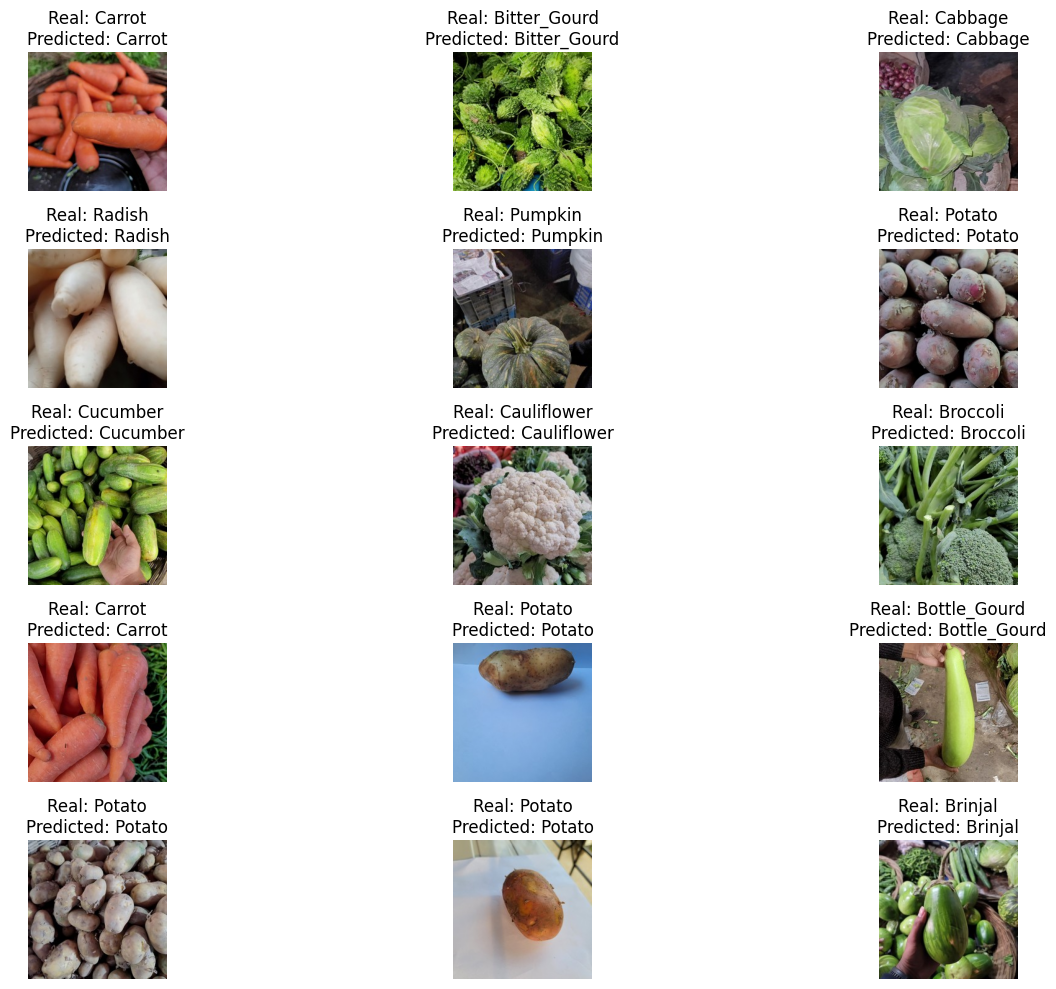

In [13]:

samples_to_display = len(categories)
fig, axes = plt.subplots(5, samples_to_display//5, figsize=(15, 10))
axes = axes.flatten()

showLoader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

for i in range(samples_to_display):
    image, label = next(iter(showLoader))
    image = image.to(device)
    label = label.to(device)
    
    output = model(image)
    _, predicted = output.max(1)
    
    image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    label = label.item()
    predicted = predicted.item()
    
    axes[i].imshow(image)
    axes[i].set_title(f'Real: {categories[label]}\nPredicted: {categories[predicted]}')
    axes[i].axis('off')    

plt.tight_layout()
plt.show()

Podemos ver la alta tasa de acierto con samples del mismo dataset.